In [10]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

[FMP Documentation](https://site.financialmodelingprep.com/developer/docs): 250 calls/day

[yFinance Documentation](https://ranaroussi.github.io/yfinance/)

In [11]:
FMP_KEY = 'eeJHb7GCfpCNRLP2wKKc4vkvT1V6H1tC'

#Financial Modeling Prep (FMP)
###API Call/Data load

In [12]:
# At first we wanted to explore the sector performance snapshot feature, but realized that it only showed change over a day.

# Market Performance Snapshot
now = datetime.now()
sectors_dict = {}
url = 'https://financialmodelingprep.com/stable/sector-performance-snapshot'
params = {
  'date': now.strftime('%Y-%m-%d'),  # creates a string of today's date in YYYY-MM-DD format
  'apikey': FMP_KEY
}

# extract data from API and put into json format
response = requests.get(url, params=params)
data = response.json()

# loop to assign dictionary key values pairs between sector and change
for sector in data:
  sectors_dict[sector['sector']] = sector['averageChange']  # averageChange reflects change from day before

# creates df from the sectors dictionary
sectors_df = pd.DataFrame.from_dict(sectors_dict, orient = 'index')
sectors_df.columns = ['Average Change']
sectors_df

,Average Change
Basic Materials,-0.417730
Communication Services,-0.810772
Consumer Cyclical,0.672925
Consumer Defensive,-0.497799
Energy,1.213164
Financial Services,0.411410
Healthcare,0.879420
Industrials,1.225385
Real Estate,0.084026
Technology,0.896302


In [48]:
# We wanted to observe change over a year, so we wrote this code to utilize the historical sector performance endpoint

days = 365  # defines number of days to view the market by
then = now - timedelta(days = days)  # sets a starting point for the historical sector perfromance
avg_list = []  # initializes a list that will hold the average yearly changes for each sector

# loop through sectors
for sector in sectors_df.index:
  url = 'https://financialmodelingprep.com/stable/historical-sector-performance'
  params = {
  'sector': sector,
  'apikey': FMP_KEY,
  'from': then.strftime('%Y-%m-%d'),
  'to': now.strftime('%Y-%m-%d')
  }
  response = requests.get(url, params=params)
  data = response.json()

  # finds average of averageChange (daily) across the time period of the historical snapshot
  sector_sum = 0
  for date in data:
    sector_sum += date['averageChange']
  avg_list.append(sector_sum/days) # assigns list in order because loop iterates through sectors in the same order as df

# add new values to df
sectors_df['Average Change/year'] = avg_list
sectors_df.sort_values(by = 'Average Change/year', ascending = False, inplace=True)
sectors_df

,Average Change,Average Change/year
Healthcare,0.879420,0.037068
Consumer Defensive,-0.497799,0.035072
Consumer Cyclical,0.672925,0.032450
Basic Materials,-0.417730,0.030766
Technology,0.896302,0.019272
Real Estate,0.084026,0.001529
Industrials,1.225385,-0.002195
Financial Services,0.411410,-0.008204
Communication Services,-0.810772,-0.023314
Energy,1.213164,-0.023450


Now we are able to evalulate how the performance of the sectors has changed over the last year.

In [15]:
# load tickers from SPY
url = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv'
sp500 = pd.read_csv(url)
sp500_tickers = sp500['Symbol'].tolist()

print(len(sp500_tickers), 'tickers loaded')
print(sp500_tickers[:30])

503 tickers loaded
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK']


In [16]:
target_sector = sectors_df.index[0]
companies_in_sector = []
for ticker_symbol in sp500_tickers:
  ticker = yf.Ticker(ticker_symbol)
  # Access the 'sector' from the info dictionary
  try:
    sector = ticker.info['sector']
    if sector == target_sector:
      companies_in_sector.append(ticker_symbol)
  except KeyError:
    print(f'Sector information for {ticker_symbol} not found. Skipping.')
  except Exception as e:
    print(f'An error occurred for {ticker_symbol}: {e}')

print(f'{len(companies_in_sector)} companies found in {target_sector} sector.')

Sector information for BRK.B not found. Skipping.
Sector information for BF.B not found. Skipping.
61 companies found in Healthcare sector.


In [17]:
companies_in_sector

['ABT',
 'ABBV',
 'A',
 'ALGN',
 'AMGN',
 'BAX',
 'BDX',
 'TECH',
 'BIIB',
 'BSX',
 'BMY',
 'CAH',
 'COR',
 'CNC',
 'CRL',
 'CI',
 'COO',
 'CVS',
 'DHR',
 'DVA',
 'DXCM',
 'EW',
 'ELV',
 'GEHC',
 'GILD',
 'HCA',
 'HSIC',
 'HOLX',
 'HUM',
 'IDXX',
 'INCY',
 'PODD',
 'ISRG',
 'IQV',
 'JNJ',
 'LH',
 'LLY',
 'MCK',
 'MDT',
 'MRK',
 'MTD',
 'MRNA',
 'MOH',
 'PFE',
 'DGX',
 'REGN',
 'RMD',
 'RVTY',
 'SOLV',
 'STE',
 'SYK',
 'TMO',
 'UNH',
 'UHS',
 'VRTX',
 'VTRS',
 'WBA',
 'WAT',
 'WST',
 'ZBH',
 'ZTS']

In [20]:
tickers = companies_in_sector

weights = {
  'pe': 0.30,
  'eps_growth_cagr': 0.25,
  'gross_margin': 0.15,
  'net_income_margin': 0.10,
  'revenue_cagr': 0.10,
  'price_cagr': 0.10
}

metric_directions = {
  'pe': 'low',  # Low PE is better, higher values are better for the other metrics
  'eps_growth_cagr': 'high',
  'gross_margin': 'high',
  'net_income_margin': 'high',
  'revenue_cagr': 'high',
  'price_cagr': 'high'
}

def calculate_cagr(start, end, years):
  # error handle by filling in problematic values with NaN, rest of code reflects this
  if start is None or end is None or years <= 0 or start == 0:
    return np.nan
  if start < 0 or end < 0: # handling for negative ratios --> complex number result
    return np.nan
  ratio = end / start
  cagr = (ratio ** (1 / years)) - 1
  return cagr


historical_data_metrics = []

for t in tickers:
  stock = yf.Ticker(t)
  print(f'Processing {t} ({stock.info.get('shortName')})...')
  metrics_dict = {'ticker': t}
  financials = pd.DataFrame()

  # Fetch Info first for PE and Shares
  info = stock.info

  # Metrics filled with NaN to avoid errors
  # PE from yF.Ticker.info
  pe_value = info.get('trailingPE')
  metrics_dict['pe'] = pe_value if pe_value else np.nan

  financials = stock.financials # Gets ~4 years

  shares = info.get('sharesOutstanding')

  # EPS Growth CAGR - Calculated from last ~4 years annual Net Income / Shares Outstanding
  eps_cagr = np.nan
  if 'Net Income' in financials.index:  # Verify column existance before checking for values in it
    net_income_series = financials.loc['Net Income'].dropna()
    if len(net_income_series) >= 2:
      eps_series = net_income_series / shares
      eps_series = eps_series.sort_index()
      end_eps = eps_series.iloc[-1]
      start_eps = eps_series.iloc[0]
      num_years_eps = len(eps_series) - 1
      if num_years_eps > 0:
         eps_cagr = calculate_cagr(start_eps, end_eps, num_years_eps)
  metrics_dict['eps_growth_cagr'] = eps_cagr

  # Gross Margin - Calculated from most recent annual Gross Profit / Revenue
  gross_margin_val = np.nan
  if 'Gross Profit' in financials.index and 'Total Revenue' in financials.index:
    gp_series = financials.loc['Gross Profit'].dropna()
    rev_series = financials.loc['Total Revenue'].dropna()
    # Align series by index (date) with intersection() and get the most recent matching pair
    common_index = gp_series.index.intersection(rev_series.index).sort_values(ascending=False)
    latest_date = common_index[0]
    latest_gp = gp_series.get(latest_date)
    latest_rev = rev_series.get(latest_date)
    gross_margin_val = latest_gp / latest_rev
  metrics_dict['gross_margin'] = gross_margin_val

  # Net Income Margin - Calculated from most recent annual Net Income / Revenue
  net_income_margin_val = np.nan
  ni_series = financials.loc['Net Income'].dropna()
  rev_series = financials.loc['Total Revenue'].dropna() # Reuse rev_series from above
  common_index_ni = ni_series.index.intersection(rev_series.index).sort_values(ascending=False)

  latest_date_ni = common_index_ni[0]
  latest_ni = ni_series.get(latest_date_ni)
  latest_rev_ni = rev_series.get(latest_date_ni)
  net_income_margin_val = latest_ni / latest_rev_ni
  metrics_dict['net_income_margin'] = net_income_margin_val

  # Revenue CAGR - Calculated from last ~4 years annual Total Revenue
  revenue_cagr = np.nan
  revenue_series = financials.loc['Total Revenue'].dropna()
  if len(revenue_series) >= 2:
    revenue_series = revenue_series.sort_index()
    end_rev = revenue_series.iloc[-1]
    start_rev = revenue_series.iloc[0]
    num_years_rev = len(revenue_series) - 1
    revenue_cagr = calculate_cagr(start_rev, end_rev, num_years_rev)
  metrics_dict['revenue_cagr'] = revenue_cagr

  # Stock Price CAGR (20 Years) - Calculated from ~20 years adjusted close price history
  price_cagr = np.nan
  hist = stock.history(period='20y', auto_adjust=True)['Close'].dropna()
  if len(hist) >= 2:
    hist = hist.sort_index()
    end_price = hist.iloc[-1]
    start_price = hist.iloc[0]
    num_years_price = (hist.index[-1] - hist.index[0]).days / 365.25
    price_cagr = calculate_cagr(start_price, end_price, num_years_price)
  metrics_dict['price_cagr'] = price_cagr

  historical_data_metrics.append(metrics_dict)

stocks_data_all = pd.DataFrame(historical_data_metrics)
print(f'Processed {len(stocks_data_all.index)} stocks.')

Processing ABT (Abbott Laboratories)...
Processing ABBV (AbbVie Inc.)...
Processing A (Agilent Technologies, Inc.)...
Processing ALGN (Align Technology, Inc.)...
Processing AMGN (Amgen Inc.)...
Processing BAX (Baxter International Inc.)...
Processing BDX (Becton, Dickinson and Company)...
Processing TECH (Bio-Techne Corp)...
Processing BIIB (Biogen Inc.)...
Processing BSX (Boston Scientific Corporation)...
Processing BMY (Bristol-Myers Squibb Company)...
Processing CAH (Cardinal Health, Inc.)...
Processing COR (Cencora, Inc.)...
Processing CNC (Centene Corporation)...
Processing CRL (Charles River Laboratories Inte)...
Processing CI (The Cigna Group)...
Processing COO (The Cooper Companies, Inc.)...
Processing CVS (CVS Health Corporation)...
Processing DHR (Danaher Corporation)...
Processing DVA (DaVita Inc.)...
Processing DXCM (DexCom, Inc.)...
Processing EW (Edwards Lifesciences Corporatio)...
Processing ELV (Elevance Health, Inc.)...
Processing GEHC (GE HealthCare Technologies Inc.)

In [34]:
stocks_data_scaled = stocks_data_all.copy()

# Drop companies that have any NaN values
metrics_to_scale = list(weights.keys())
original_count = len(stocks_data_scaled)
stocks_data_scaled = stocks_data_scaled.dropna(subset=metrics_to_scale)
dropped_count = original_count - len(stocks_data_scaled)
print(f'Dropped {dropped_count} stocks due to missing data for scoring metrics. {len(stocks_data_scaled)} remaining.')

if stocks_data_scaled.empty:
   print('Error: No stocks remaining after dropping rows with missing metric data. Cannot score.')
else:
  scaler = MinMaxScaler()

  for metric in metrics_to_scale:
    scaled_col_name = f'{metric}_scaled'
    # Guarantee metric is float and reshape it into 2D array for MinMaxScaler to work
    metric_data = stocks_data_scaled[metric].astype(float).values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(metric_data)

    # Accounts for low value being better for PE by taking additive inverse of 'low' metric directions
    if metric_directions.get(metric) == 'high':
      stocks_data_scaled[scaled_col_name] = scaled_data
      print(f'Scaled '{metric}' (Higher is better)')
    else: # 'low'
      stocks_data_scaled[scaled_col_name] = 1 - scaled_data
      print(f'Scaled '{metric}' (Lower is better)')

  stocks_data_scaled['final_score'] = 0.0

  # Calculuate weighted average of each scaled metric into final_score
  for metric in metrics_to_scale:
    scaled_col_name = f'{metric}_scaled'
    if scaled_col_name in stocks_data_scaled.columns:
      stocks_data_scaled['final_score'] += stocks_data_scaled[scaled_col_name] * weights[metric]


stocks_data_scaled = stocks_data_scaled.sort_values(by='final_score', ascending=False).round(4)
top_5 = stocks_data_scaled.head()
print(f'Top 5 Recommended stocks to Invest in: \n{top_5[['ticker','final_score']]}')

Dropped 11 stocks due to missing data for scoring metrics. 50 remaining.
Scaled 'pe' (Lower is better)
Scaled 'eps_growth_cagr' (Higher is better)
Scaled 'gross_margin' (Higher is better)
Scaled 'net_income_margin' (Higher is better)
Scaled 'revenue_cagr' (Higher is better)
Scaled 'price_cagr' (Higher is better)
Top 5 Recommended stocks to Invest in: 
   ticker  final_score
21     EW       0.6898
31   PODD       0.6678
39    MRK       0.6329
53    UHS       0.6319
45   REGN       0.6250


In [36]:
# Output the P/E multiples for the top 5 companies
print('Top 5 companies\' P/E multiples:')
print(top_5[['ticker','pe']])

Top 5 companies' P/E multiples:
   ticker       pe
21     EW  32.0293
31   PODD  98.3161
39    MRK  13.4361
53    UHS  10.9913
45   REGN  14.5010


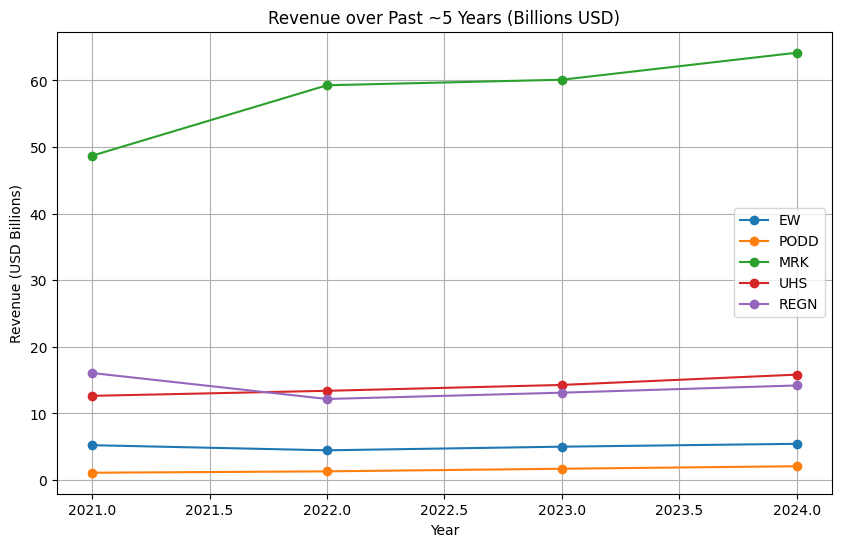

In [40]:
# Create a plot of Revenue for the top 5 stocks
tickers = top_5['ticker'].tolist()

plt.figure(figsize=(10,6))

for t in tickers:
  ticker = yf.Ticker(t)
  fin = ticker.financials  # Annual income statement
  if 'Total Revenue' in fin.index:
    revenue = fin.loc['Total Revenue']
    revenue = revenue.sort_index()
    years = [d.year for d in revenue.index]
    plt.plot(years, revenue.values / 1e9, marker='o', label=t)

plt.title('Revenue over Past ~5 Years (Billions USD)')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Billions)')
plt.legend()
plt.grid(True)
plt.show()


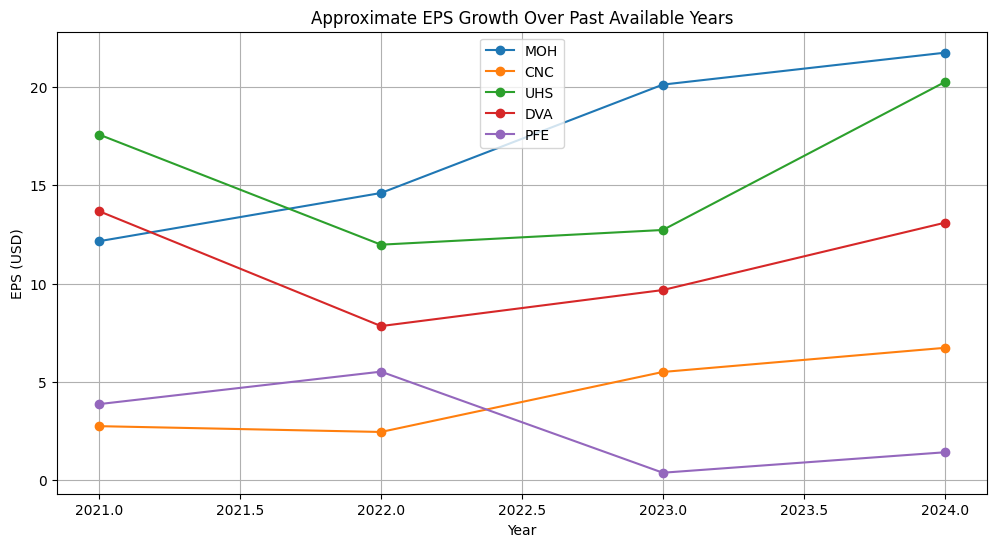

In [41]:
# Plot EPS Growth of top 5 companies using past 4 years from yFinance income statement/balance sheet
plt.figure(figsize=(12,6))

for t in ticks:
  ticker = yf.Ticker(t)

  fin = ticker.financials

  # Annual balance sheet (to get shares outstanding if needed)
  bs = ticker.balance_sheet

  # Use 'Net Income' for EPS calculation
  if 'Net Income' in fin.index:
    net_income = fin.loc['Net Income'] / 1e6  # convert to millions USD
    # If we want per share, approximate with current shares outstanding
    shares = ticker.info.get('sharesOutstanding', 1)
    eps = net_income / (shares / 1e6)  # EPS in USD
    # Use years as x-axis
    years = [d.year for d in net_income.index]
    plt.plot(years, eps.values, marker='o', label=t)

plt.title('Approximate EPS Growth Over Past Available Years')
plt.xlabel('Year')
plt.ylabel('EPS (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Display Net Income Margin and Gross Profit Margin of the top_5 companies
print('Top 5 companies\' Net Income Margin and Gross Profit Margin:')
print(top_5[['ticker','net_income_margin','gross_margin']])

Top 5 companies' Net Income Margin and Gross Profit Margin:
   ticker  net_income_margin  gross_margin
21     EW             0.7675        0.7946
31   PODD             0.2019        0.6979
39    MRK             0.2668        0.7632
53    UHS             0.0722        0.8997
45   REGN             0.3107        0.8613


/tmp/ipython-input-497704637.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start='2003-10-21', end='2023-10-21')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-497704637.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start='2003-10-21', end='2023-10-21')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-497704637.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start='2003-10-21', end='2023-10-21')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-497704637.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start='2003-10-21', end='2023-10-21')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-497704637.py:

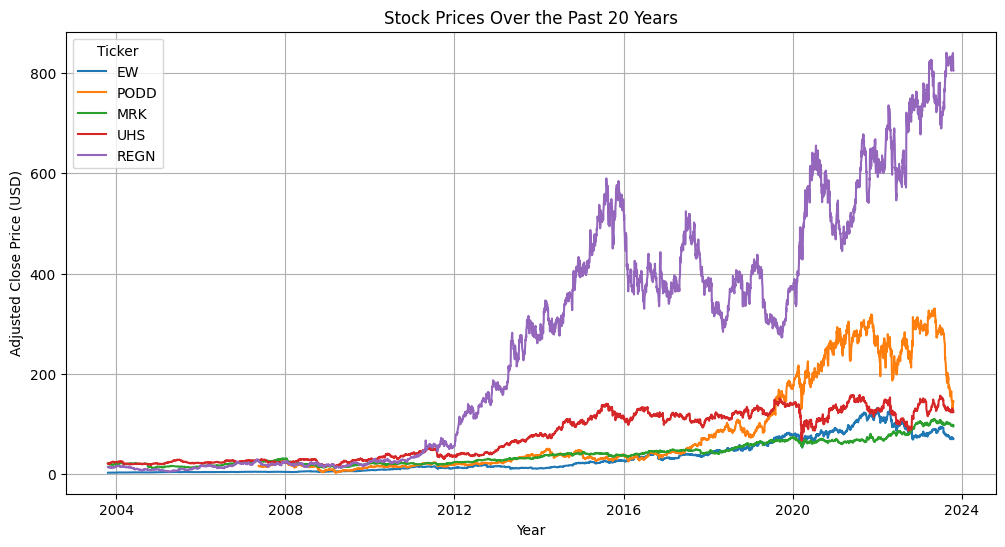

In [46]:
# Display change in stock price over last 20 years
tickers = top_5['ticker'].tolist()
adj_close_data = pd.DataFrame()

for t in tickers:
  # Download data from yFinance
  df = yf.download(t, start='2003-10-21', end='2023-10-21')
  # Use the prices from market close
  adj_close_data[t] = df['Close']

# Plot the stock prices
plt.figure(figsize=(12,6))
for t in tickers:
  plt.plot(adj_close_data.index, adj_close_data[t], label=t)

plt.title('Stock Prices Over the Past 20 Years')
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend(title='Ticker')
plt.grid(True)
plt.show()